# Lab 03: Model Fitting

In this lab, you'll implement and play with the algorithms taught in course 4. 

Export this file as PDF and submit it to the course portal.

- Student Name: 你的名字
- Student ID: 你的学号
- Date: 2024-10-10

In [1]:
# some libraries we need for this experiment, you can import anything else as you like.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import leastsq

pi = np.pi

## Fit an ellipse... 
### We provide 753 3d points with noise and you should fit an ellipse with these data points.

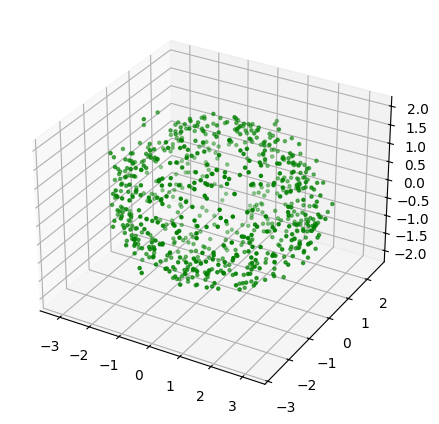

Data shape is (753, 3). First 5 rows of data: 
 [[-1.7479  -1.2471  -0.97522]
 [ 0.87797  0.26425  1.7506 ]
 [-0.56663  1.6488  -0.75284]
 [-2.821   -0.57315 -0.10787]
 [-2.1519  -0.5112   0.59752]]


In [4]:
# Visualize
def _show(x, y, z, color="g"):
    fig = plt.figure(figsize=(4, 4))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.scatter(x, y, z, c=color, marker="o", s=5)
    plt.show()


# We always see the data first to understand what we are doing.
data = np.loadtxt("data.txt")
_show(data[:, 0], data[:, 1], data[:, 2])

print(f"Data shape is {data.shape}. First 5 rows of data: \n", data[:5])

### Consider the ellipse function:
$$x^2 / A^2 + y^2 / B^2 + z^2 / C^2 = 1$$

In [8]:
# We define ellipse function.
def func(p, x):
    a, b, c = p
    return x[:, 0] ** 2 / a**2 + x[:, 1] ** 2 / b**2 + x[:, 2] ** 2 / c**2


# Then define the residual function.
def residual(p, x):
    res = func(p, x) - 1
    return res

### We resort to scipy to help us with this problem

[2.94404668 2.30503544 1.7978253 ]
Mean absolute error is 0.1369536298335725


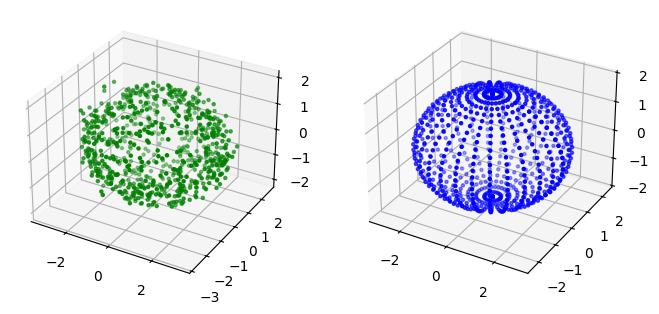

In [9]:
# Luckily, scipy has provided functions we need here.
p_init = [1, 1, 1]  # initial guess
p_solved = leastsq(residual, p_init, args=(data))[0]
print(p_solved)

# Check the error
error = residual(p_solved, data)
error_mean = np.mean(np.abs(error))
print(f"Mean absolute error is {error_mean}")


# Visualize the fitted ellipse over observed data
def _param_func_show(params, data):
    point_num = 30
    theta = np.linspace(0, pi, point_num)
    fi = np.linspace(0, 2 * pi, point_num)
    x = params[0] * np.sin(theta)[:, np.newaxis] * np.cos(fi)[np.newaxis, :]
    y = params[1] * np.sin(theta)[:, np.newaxis] * np.sin(fi)[np.newaxis, :]
    z = params[2] * np.cos(theta)[:, np.newaxis] * np.ones(point_num)[np.newaxis, :]

    fig = plt.figure(figsize=(8, 4))
    ax_ = fig.add_subplot(1, 2, 1, projection="3d")
    ax_.scatter(data[:, 0], data[:, 1], data[:, 2], c="g", marker="o", s=5)
    ax_ = fig.add_subplot(1, 2, 2, projection="3d")
    ax_.scatter(x.reshape(-1), y.reshape(-1), z.reshape(-1), c="b", marker="o", s=5)
    plt.show()


_param_func_show(p_solved, data)

# It's your turn now!

Now you are an expert of optimization after the lesson. It's time to solve this problem by yourself:

You should solve this problem with Gauss-Newton method.
To help you with this, we have provided some functions you may need.

If this pipeline restricts you, feel free to implement your own one. But you should add clear comments to your own pipeline to make others understand quickly.

In [2]:
# Target:x^2 / A^2 + y^2 / B^2 + z^2 / C^2 = 1
# Gauss-Newton method:\Delta x = -(J_R.T J_R)^{-1}J_R.T R(x_k)

def res(param, data):
    """
    Args:
        param: the parameters you want to optimize
        data: the data you need to fit
    Returns:
        res: the residual of the points with objective function
    """
    a, b, c = param
    res = data[:, 0] ** 2 / a**2 + data[:, 1] ** 2 / b**2 + data[:, 2] ** 2 / c**2 - 1
    return res


def jacobi(param, data):
    """
    Args:
        param: the parameters you want to optimize
        data: the data you need to fit
    Returns:
        d: the jacobi of the objective function with these data points and parameters
    """
    a, b, c = param
    d = np.zeros((len(data), 3))
    d[:, 0] = -2 * data[:, 0]**2 / a**3  
    d[:, 1] = -2 * data[:, 1]**2 / b**3  
    d[:, 2] = -2 * data[:, 2]**2 / c**3  
    return d


def solve_delta(params, data):
#\Delta x = -(J_R.T J_R)^{-1}J_R.T R(x_k)
    """
    Args:
        param: the parameters you want to optimize
        data: the data you need to fit
    Returns:
        delta_p: the optimal direction of the parameters
    """
    J = jacobi(params, data)
    r = res(params, data)
    # solve the linear equation,avoid computing the inverse
    JTJ = J.T @ J
    JTr = J.T @ r
    try:
        delta_p = -np.linalg.solve(JTJ, JTr)
    except np.linalg.LinAlgError: # if cannot compute the inverse
        delta_p = -np.linalg.pinv(JTJ) @ JTr # use Pseudo-inverse
    return delta_p

In [22]:
# Choose a start point, maybe [1.0, 1.0, 1.0]? What would happen if you choose a bad start point?
# too large -> Runtimewarning,[0, 0, 0] -> NaN
p0 = [1.0, 1.0, 1.0]
k = 0
max_k = 10000
# Choose a good step size!
step = 1.0
# Determine the condition of delta_p
eps = 1e-8
p = np.array(p0, dtype=np.float64)
while k < max_k:
    d_p = solve_delta(p, data)
    if np.abs(d_p).mean() < eps:
        break
    p += step * d_p
    k += 1
print(p, k)

[2.94404668 2.30503544 1.7978253 ] 7


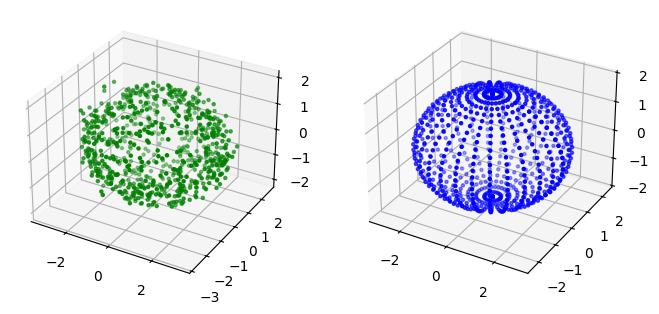

In [20]:
# Visualize the fitted ellipse over observed data
_param_func_show(p, data)